In [ ]:
#!pip install seaborn
#!pip install librosa
#!pip install scikit-image
#!pip install datasets

In [ ]:
#!pip install kaggle

In [ ]:
#!ls

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os as os
import tensorflow as tf
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold


from joblib import delayed, Parallel
from tqdm import tqdm


import librosa
import librosa.display
import IPython.display as ipd
import skimage.io

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !zip [ZIP FILE NAME . zip] [Location of Folder to ZIP]
#!zip -r processed_train.zip /content/drive/MyDrive/Colab_Nb/data/processed_train

In [ ]:
# !zip [ZIP FILE NAME . zip] [Location of Folder to ZIP]
#!zip -r kaggle-pog-series-s01e02.zip  /content/drive/MyDrive/Colab_Nb/data/kaggle-pog-series-s01e02

In [ ]:
!mkdir /content/drive/MyDrive/Colab_Nb/data/

In [ ]:
!mkdir /content/unzip_data

In [ ]:
#!unzip -d /content/drive/MyDrive/Colab_Nb/data/ /content/drive/MyDrive/Colab_Nb/kaggle-pog-series-s01e02.zip

In [ ]:
#!7z e /content/drive/MyDrive/Colab_Nb/data/kaggle-pog-series-s01e02.zip -o/content/drive/MyDrive/Colab_Nb/data/

In [ ]:
# move back to location where we want to extract the zip file in colab temp drive
# !cd [Location of colab drive]
!cd /content/unzip_data

In [ ]:
#!7z e /content/processed_train.zip -o/content/unzip_data/

In [ ]:
#!ls

Loading training and testing CSV datasets

In [3]:
# Defining variables

NUM_MEL_SPECS = 1

class DataPath:
    def __init__(self, data, audio_path, process, processed_train, processed_test):
        self.data = data
        self.audio = audio_path
        self.process = process
        self.protrain = processed_train
        self.protest =  processed_test



DATA_PATH = "/content/drive/MyDrive/Colab_Nb/data/"
AUDIO_PATH = DATA_PATH + "train/"
PROCESSED_TRAIN_DATA = "/content/drive/MyDrive/Colab_Nb/data/processed_train/"
PROCESSED_TEST_DATA = "/content/drive/MyDrive/Colab_Nb/data/processed_test/"

PATH = DataPath(DATA_PATH, AUDIO_PATH, 'data/processed/', PROCESSED_TRAIN_DATA, PROCESSED_TEST_DATA)

TRAIN_ERA = 2
MODEL_NAME = 'music_genre.keras'
MODEL_PATH = '/content/drive/MyDrive/Colab_Nb/models'

BATCH_SIZE = 32
lot = 1    # multiple of 19_000 // 500
img_width, img_height, img_num_channels = 256, 938, 1
loss_function = categorical_crossentropy
nb_classes = 19
nb_epochs = 10
optimizer = Adam()
verbosity = 1
shuffle = True

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

In [36]:
# load metadata into pandas dataframes

df_known = pd.read_csv(PATH.data + 'train.csv')
df_test = pd.read_csv(PATH.data + 'test.csv')
df_genres = pd.read_csv(PATH.data + 'genres.csv')
#submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/kaggle-pog-series-s01e02/sample_submission.csv')
df_known

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
...,...,...,...,...,...
19917,9337,009337.ogg,train/009337.ogg,0,Electronic
19918,8340,008340.ogg,train/008340.ogg,4,Hip-Hop
19919,16248,016248.ogg,train/016248.ogg,4,Hip-Hop
19920,11875,011875.ogg,train/011875.ogg,2,Punk


In [37]:
#remove rows from dataframe that don't exist as an audio file

df_known = df_known[[os.path.isfile(PATH.data + i) for i in df_known['filepath']]]
df_test = df_test[[os.path.isfile(PATH.data + i) for i in df_test['filepath']]]

df_known

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
...,...,...,...,...,...
19917,9337,009337.ogg,train/009337.ogg,0,Electronic
19918,8340,008340.ogg,train/008340.ogg,4,Hip-Hop
19919,16248,016248.ogg,train/016248.ogg,4,Hip-Hop
19920,11875,011875.ogg,train/011875.ogg,2,Punk


In [41]:
df_test

,song_id,filename,filepath
0,7072,007072.ogg,test/007072.ogg
1,10207,010207.ogg,test/010207.ogg
2,20008,020008.ogg,test/020008.ogg
3,10924,010924.ogg,test/010924.ogg
4,21896,021896.ogg,test/021896.ogg
...,...,...,...
5073,6427,006427.ogg,test/006427.ogg
5074,16903,016903.ogg,test/016903.ogg
5075,1731,001731.ogg,test/001731.ogg
5076,12871,012871.ogg,test/012871.ogg


In [22]:
df_genres

,genre,genre_id
0,Electronic,0
1,Rock,1
2,Punk,2
3,Experimental,3
4,Hip-Hop,4
5,Folk,5
6,Chiptune / Glitch,6
7,Instrumental,7
8,Pop,8
9,International,9


In [28]:
df_genres.loc[df_genres['genre_id'] == 3, 'genre'].values[0]

'Experimental'

In [6]:
# function to load audio file and resample it
def load_ogg_16k_mono(filename):
    # Load encoded ogg file

    # Decode ogg file
    y, sr = librosa.load(filename)
    #convert all files to mono (if not already)
    y = librosa.to_mono(y)
    # Goes to 16000hz - reduced sample rate within human hearing
    y = librosa.resample(y, orig_sr=sr, target_sr=16000)
    return y

Extracting waveform array data and sample rate for the first training audio file

Plotting raw waveform

In [49]:
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=input_shape,
                 shuffle=shuffle,
                 from_npy = False):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.from_npy = from_npy

        self.n = len(self.df)
        if y_col != None:
          self.n_type = df[y_col].nunique()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, path):
      if self.from_npy == True:
        path = path.split('.')[0]
        path = path.split('/')[-1]
        melnorm = np.load(PATH.protrain + 'mels/'+path+'.npy', allow_pickle = True)
        melnorm = np.expand_dims(melnorm, -1)
        return melnorm
      else:
        ogg = load_ogg_16k_mono(PATH.data + path)
        ogg = ogg[:480000]
        zero_padding = np.zeros((480000) - np.shape(ogg)[0], dtype=np.float32)
        ogg = np.concatenate((zero_padding, ogg),0)
        S = librosa.feature.melspectrogram(y=ogg,sr=16000,n_mels=128 * 2,)
        S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
        melnorm = librosa.util.normalize(S_db_mel)
        melnorm = np.expand_dims(melnorm, -1)
        return melnorm

    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=nb_classes)

    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col]
        X_batch = np.asarray([self.__get_input(x) for x in path_batch])

        if self.y_col == None:
          y1_batch = 0
        else:
          type_batch = batches[self.y_col]
          y1_batch = np.asarray([self.__get_output(y, self.n_type) for y in type_batch])

        return X_batch, y1_batch

    def __getitem__(self, index):

        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y

    def __len__(self):
        return self.n // self.batch_size

In [8]:
df_train = df_known.iloc[1000*(TRAIN_ERA-1):1000*TRAIN_ERA,:]
#df_test = df_known.iloc[450:500,:]

In [ ]:
labels = np.load('/content/drive/MyDrive/Colab_Nb/data/processed_train/labels.npy')

In [ ]:
labels = tf.keras.utils.to_categorical(labels, 19)

In [9]:
#initiate data generator
gen_train = CustomDataGen(df_train, 'filepath', 'genre_id', BATCH_SIZE, from_npy = True)

In [19]:
image_batch, label_batch = next(iter(gen_train))

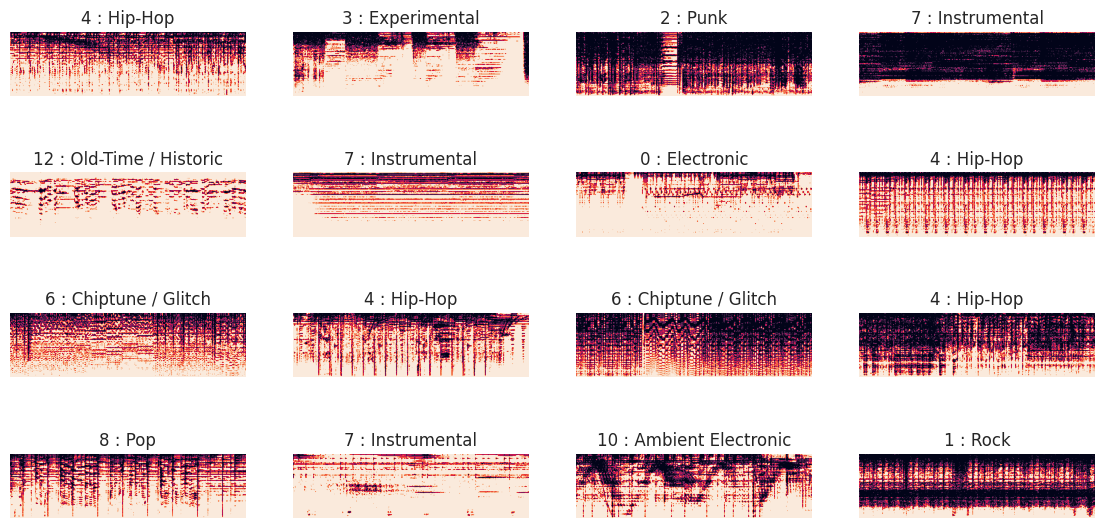

In [35]:
#image_batch, label_batch = next(iter(gen_train))
plt.figure(figsize=(14, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = label_batch[i]
    label = np.argmax(label)
    title = df_genres.loc[df_genres['genre_id'] == label, 'genre'].values[0]
    plt.title(str(label) + " : " + title)
    plt.axis("off")

In [ ]:
print(np.shape(y_train))

(32, 19)


In [51]:
# load existing trained model or create new one
if os.path.exists(MODEL_PATH + MODEL_NAME):

  model = tf.keras.models.load_model(MODEL_PATH + MODEL_NAME)

else:

  lc0 = tf.keras.layers.Conv2D(16, (5,5), input_shape=input_shape, name='input')
  acti1 = tf.keras.layers.ELU()
  lc1 = tf.keras.layers.Dropout(.15)
  lc2 = tf.keras.layers.BatchNormalization()
  lc3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')

  lc4 = tf.keras.layers.Conv2D(32, (3,3))
  acti2 = tf.keras.layers.ELU()
  lc5 = tf.keras.layers.Dropout(.15)
  lc6 = tf.keras.layers.BatchNormalization()
  lc7 = tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same')

  lc8 = tf.keras.layers.Conv2D(64, (3,3))
  acti3 = tf.keras.layers.ELU()
  lc9 = tf.keras.layers.Dropout(.15)
  lc10 = tf.keras.layers.BatchNormalization()
  lc11 = tf.keras.layers.MaxPool2D(pool_size=(4,4),padding='same')

  lc12 = tf.keras.layers.Conv2D(128, (3,3))
  acti4 = tf.keras.layers.ELU()
  lc13 = tf.keras.layers.Dropout(.15)
  lc14 = tf.keras.layers.BatchNormalization()
  lc15 = tf.keras.layers.MaxPool2D(pool_size=(4,4),padding='same')

  rs = tf.keras.layers.Reshape((-1, 128))
  lf = tf.keras.layers.Flatten()

  gr1 = tf.keras.layers.GRU(24, return_sequences=True)
  gr2 = tf.keras.layers.GRU(24, return_sequences=False)
  gr3 = tf.keras.layers.Dropout(0.3)

  ld1 = tf.keras.layers.Dense(32, activation='relu')
  ld2 = tf.keras.layers.Dropout(.5)
  ld3 = tf.keras.layers.BatchNormalization()

  lfinal = tf.keras.layers.Dense(nb_classes, activation='softmax', name='output')

  model = tf.keras.Sequential([lc0, acti1,lc1,lc2,lc3,lc4,acti2,lc5,lc6,lc7,lc8,acti3,lc9,lc10,lc11,lc12,acti4,lc13,lc14,lc15,rs,gr1,gr2,gr3,lfinal], name="model_example")
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 252, 934, 16)      416       
                                                                 
 elu_16 (ELU)                (None, 252, 934, 16)      0         
                                                                 
 dropout_24 (Dropout)        (None, 252, 934, 16)      0         
                                                                 
 batch_normalization_20 (Ba  (None, 252, 934, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 126, 467, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 124, 465, 32)    

In [ ]:
# create directory to store trained models
!mkdir /content/drive/MyDrive/Colab_Nb/models/

In [ ]:
# Fit data to model
history = model.fit(gen_train,
              batch_size=BATCH_SIZE,
              epochs=nb_epochs,
              verbose=verbosity)

# Generate generalization metrics
#scores = model.evaluate(tf.gather(inputs, test), tf.gather(targets, test), verbose=0)

Epoch 1/10
31/31 [==============================] - 773s 25s/step - loss: 0.5206 - accuracy: 0.0766
Epoch 2/10
31/31 [==============================] - 14s 438ms/step - loss: 0.3546 - accuracy: 0.0948
Epoch 3/10
31/31 [==============================] - 11s 339ms/step - loss: 0.2656 - accuracy: 0.0897
Epoch 4/10
31/31 [==============================] - 11s 340ms/step - loss: 0.2324 - accuracy: 0.1129
Epoch 5/10
31/31 [==============================] - 11s 340ms/step - loss: 0.2160 - accuracy: 0.0978
Epoch 6/10
31/31 [==============================] - 11s 340ms/step - loss: 0.2088 - accuracy: 0.1361
Epoch 7/10
31/31 [==============================] - 11s 341ms/step - loss: 0.2029 - accuracy: 0.1562
Epoch 8/10
31/31 [==============================] - 11s 342ms/step - loss: 0.2007 - accuracy: 0.1331
Epoch 9/10
31/31 [==============================] - 11s 343ms/step - loss: 0.1989 - accuracy: 0.1502
Epoch 10/10
31/31 [==============================] - 11s 344ms/step - loss: 0.1961 - accurac

In [ ]:
model.save('/content/drive/MyDrive/Colab_Nb/models/music_genre.keras')

Predictions on one unseen batch and Spectogram visualisation

In [53]:
df_test = df_test.iloc[:32,:]

In [54]:
gen_test = CustomDataGen(df_test, 'filepath', None, BATCH_SIZE, from_npy = False)

In [57]:
image_batch, _ = gen_test[0]

In [56]:
pred = model.predict(gen_test, workers=4, verbose = True)
pred_labels = np.argmax(pred, axis = -1)

1/1 [==============================] - 6s 6s/step


In [59]:
pred_labels

array([12, 12, 12, 12, 12, 12,  7, 12, 12,  7, 12,  7, 12, 12, 12, 12, 12,
        7, 12, 12, 12, 12,  7, 12, 12, 12, 12,  7,  7,  7, 12, 12])

In [60]:
label_batch = pred

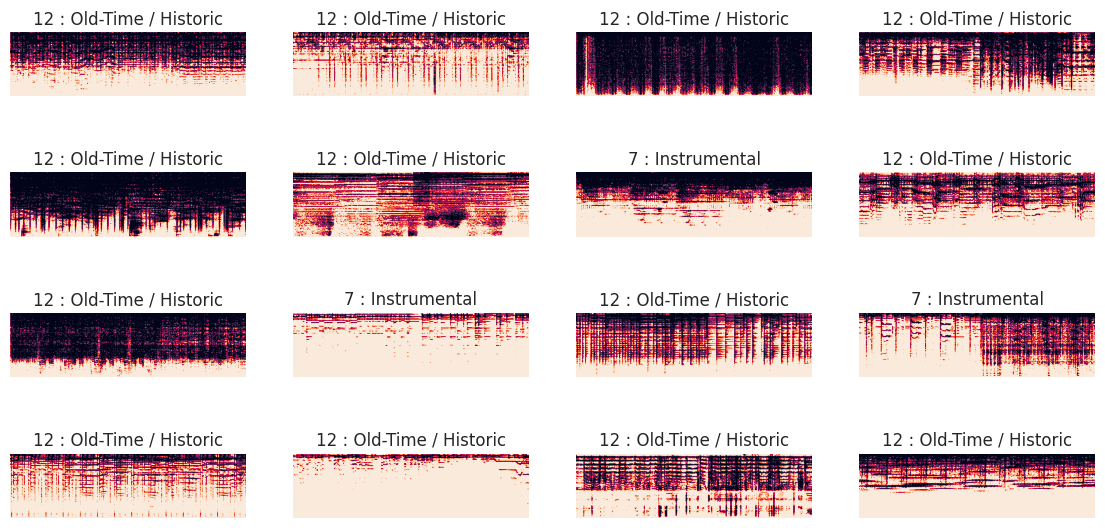

In [61]:
plt.figure(figsize=(14, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = label_batch[i]
    label = np.argmax(label)
    title = df_genres.loc[df_genres['genre_id'] == label, 'genre'].values[0]
    plt.title(str(label) + " : " + title)
    plt.axis("off")

In [ ]:
inputs = X_train
targets = y_train

In [ ]:
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True)

acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets.argmax(1)):

  # Define the model architecture
  model = tf.keras.Sequential([lc0, acti1,lc1,lc2,lc3,
                               lc4,acti2,lc5,lc6,lc7,
                               lc8,acti3,lc9,lc10,lc11,
                               lc12,acti4,lc13,lc14,lc15,
                               rs,gr1,gr2,gr3,lfinal],
                                name="model_example")


  # Compile the model
  model.compile(loss=loss_function,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
  model.summary()


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(tf.gather(inputs, train), tf.gather(targets, train),
              batch_size=BATCH_SIZE,
              epochs=nb_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(tf.gather(inputs, test), tf.gather(targets, test), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])



  # Increase fold number
  fold_no = fold_no + 1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model: "model_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 252, 934, 16)      416       
                                                                 
 elu (ELU)                   (None, 252, 934, 16)      0         
                                                                 
 dropout (Dropout)           (None, 252, 934, 16)      0         
                                                                 
 batch_normalization (Batch  (None, 252, 934, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 467, 16)      0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 124, 465, 32)    

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.8474016189575195 - Accuracy: 14.000000059604645%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.9830520153045654 - Accuracy: 12.999999523162842%
------------------------------------------------------------------------
> Fold 3 - Loss: 3.244926691055298 - Accuracy: 12.999999523162842%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.443770170211792 - Accuracy: 14.000000059604645%
------------------------------------------------------------------------
> Fold 5 - Loss: 3.4594216346740723 - Accuracy: 14.000000059604645%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 13.599999845027924 (+- 0.4898982113583744)
> Loss: 3.1957144260406496
------------------------